In [2]:
from pathlib import Path
from dataclasses import dataclass
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing import Any
from sklearn.preprocessing import OneHotEncoder
import shap

%matplotlib inline
%load_ext autoreload
%autoreload 2


@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"


config = Config()

sys.path.append(str(config.REPO_ROOT))

/Users/shim-kojio/Documents/ramble/Interpretable_machine_learning_by_python/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from python.src.preprocess import (
    preprocess_rfcc,
)

df_rfcc = pd.read_csv(config.data_dir / "risk_factors_cervical_cancer.csv")
df_rfcc_preprocessed = preprocess_rfcc(df=df_rfcc)
assert df_rfcc.shape[0] == df_rfcc_preprocessed.shape[0]

In [4]:
X = df_rfcc_preprocessed.drop("Biopsy", axis=1)
y = df_rfcc_preprocessed["Biopsy"].map({"Healthy": 0, "Cancer": 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


rf_model = RandomForestClassifier(random_state=43)  # random_stateで再現性を確保
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=43)

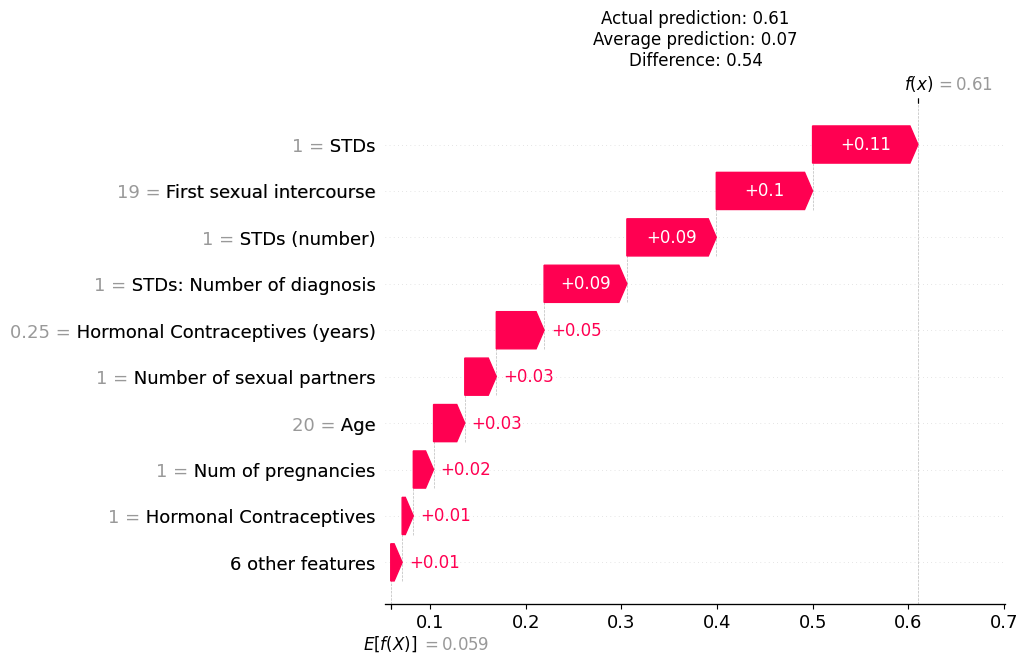

In [8]:
# Create a SHAP explainer
explainer = shap.Explainer(rf_model, X)

instance_index = 325  # Python indexing starts from 0
x_interest = X.iloc[[instance_index]]


# Calculate SHAP values (for the positive class - index 1)
shap_values = explainer(x_interest)

# *** This is the key correction ***
shap_values_for_plot = shap_values[
    0, :, 1
]  # select [instance, all features, postive class index]


# Calculate average prediction for the positive class (index 1)
avg_prediction = rf_model.predict_proba(X)[:, 1].mean()

# Get the actual prediction for the instance of interest (positive class)
actual_prediction = rf_model.predict_proba(x_interest)[
    0, 1
]  # Accessing probability directly

diff_prediction = actual_prediction - avg_prediction

# Create the SHAP force plot (corrected)
shap.plots.waterfall(shap_values_for_plot, show=False)  # Use shap_values_for_plot
plt.title(
    f"Actual prediction: {actual_prediction:.2f}\nAverage prediction: {avg_prediction:.2f}\nDifference: {diff_prediction:.2f}"
)
plt.ylabel("Feature value contribution")
plt.show()

In [11]:
from python.src.preprocess import (
    preprocess_bike_data,
)

df_bike = pd.read_csv(config.data_dir / "bike+sharing+dataset" / "day.csv")
df_bike_processed = preprocess_bike_data(df=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

df_bike_processed["holiday"] = df_bike_processed["holiday"].map(
    {"HOLIDAY": 1, "NO HOLIDAY": 0}
)
df_bike_processed["season"] = df_bike_processed["season"].map(
    {
        "WINTER": 1,
        "SPRING": 2,
        "SUMMER": 3,
        "FALL": 4,
    }
)
df_bike_processed["workingday"] = df_bike_processed["workingday"].map(
    {"WORKING DAY": 1, "NO WORKING DAY": 0}
)
df_bike_processed["mnth"] = df_bike_processed["mnth"].map(
    {
        "JAN": 1,
        "FEB": 2,
        "MAR": 3,
        "APR": 4,
        "MAY": 5,
        "JUN": 6,
        "JUL": 7,
        "AUG": 8,
        "SEP": 9,
        "OCT": 10,
        "NOV": 11,
        "DEC": 12,
    }
)
df_bike_processed["weekday"] = df_bike_processed["weekday"].map(
    {
        "SUN": 1,
        "MON": 2,
        "TUE": 3,
        "WED": 4,
        "THU": 5,
        "FRI": 6,
        "SAT": 7,
    }
)
df_bike_processed["weathersit"] = df_bike_processed["weathersit"].map(
    {"MISTY": 1, "GOOD": 2, "RAIN/SNOW/STORM": 3}
)
X = df_bike_processed.drop(columns="cnt")
y = df_bike_processed["cnt"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
rf_model_train = RandomForestRegressor(random_state=43)  # random_stateで再現性を確保
rf_model_train.fit(X_train, y_train)

RandomForestRegressor(random_state=43)

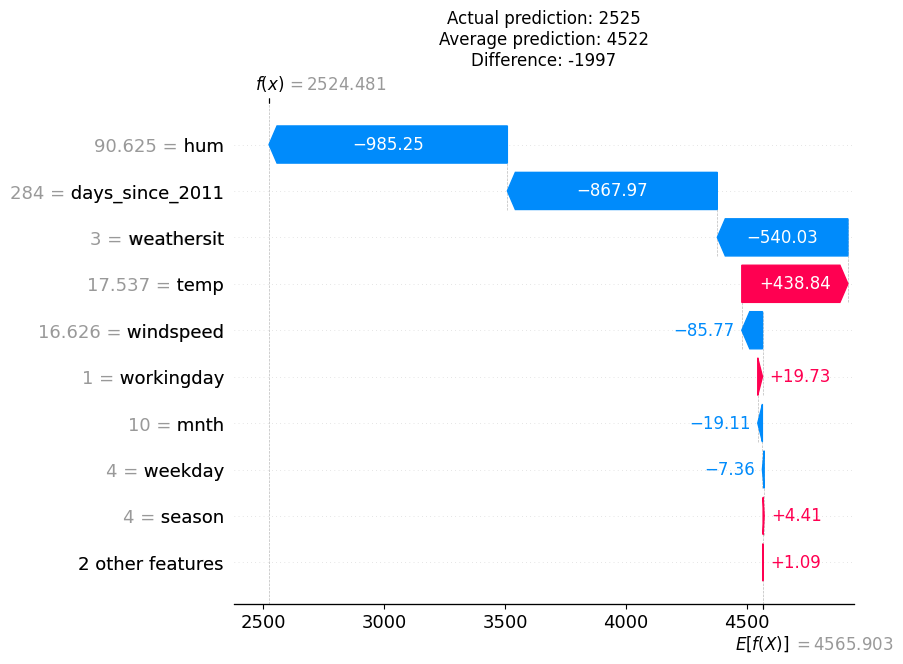

In [12]:
# Create the SHAP explainer
explainer = shap.Explainer(rf_model_train, X)

instance_indices = [294, 284]  # Adjust to Python's 0-based indexing
x_interest = X.iloc[[instance_indices[1]]]


# Calculate SHAP values
shap_values = explainer(x_interest)


avg_prediction = rf_model_train.predict(X).mean()
actual_prediction = rf_model_train.predict(x_interest)[0]
diff_prediction = actual_prediction - avg_prediction


# Create the SHAP waterfall plot
shap.plots.waterfall(shap_values[0], show=False)
plt.title(
    f"Actual prediction: {actual_prediction:.0f}\nAverage prediction: {avg_prediction:.0f}\nDifference: {diff_prediction:.0f}"
)
plt.ylabel("Feature value contribution")
plt.show()